# Семинар 9

##  Сдвиги для ускорения методов вычисления собственных значений

## Степенной метод: напоминание

- Задача поиска максимального по модулю собственного значения
- Сходимость линейная, коэффициент $\frac{|\lambda_2|}{|\lambda_1|}$
- Может не сходиться. В каком случае?
- Сложность пропорциональна сложности умножения матрицы на вектор

## Сдвиги для ускорения сходимости степенного метода

- Степенной метод 

\begin{align*}
& x_{k+1} = A x_k\\
& x_{k+1} := \frac{x_{k+1}}{\|x_{k+1}\|}
\end{align*}

- Метод обратной итерации со сдвигами

\begin{align*}
& x_{k+1} = (A - \sigma I)^{-1} x_k\\
& x_{k+1} := \frac{x_{k+1}}{\|x_{k+1}\|}
\end{align*}

- Куда сойдётся?

In [92]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as splin

def shift_inverse_iteration(A, x0, num_iter, shift=0.):
    x = x0.copy()
    conv = [x]
    n = A.shape[0]
    for i in range(num_iter):
        x = np.linalg.solve(A - shift * np.eye(n), x)
        x = x / np.linalg.norm(x)
        conv.append(x)
    return x, conv

def shift_inverse_iteration_fast(A, x0, num_iter, shift=0.):
    x = x0.copy()
    conv = [x]
    n = A.shape[0]
    lu_factor = splin.lu_factor(A - shift * np.eye(n))
    for i in range(num_iter):
        x = splin.lu_solve(lu_factor, x)
        x = x / np.linalg.norm(x)
        conv.append(x)
    return x, conv

[0.01811231 0.04519876 0.04519876 ... 7.95480124 7.95480124 7.98188769]


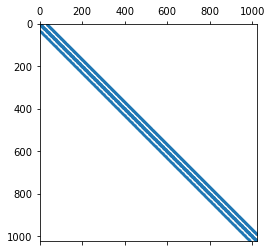

In [95]:
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
n = 32
A = np.random.randn(n, n)
A = A.T @ A + np.eye(n)

L1d = spsp.spdiags((-1*np.ones(n), 2 * np.ones(n), -1*np.ones(n)), [-1, 0, 1], n, n)
L2d = spsp.kronsum(L1d, L1d)
plt.spy(L2d, markersize=1)
A = L2d.toarray()
# A = A + A.T
# Q, _ = np.linalg.qr(A)
# d = (np.random.rand(n) + 10) * 10
# d[0] = 1
# d[1] = 2
# Lam = np.diag(d)
# print(Lam.shape)
# A = Q @ Lam @ Q.T
true_spectrum = np.linalg.eigvalsh(A)
print(np.sort(true_spectrum))
x0 = np.random.randn(A.shape[0])
num_iter = 40

In [96]:
smallest_eigv, conv_sm = shift_inverse_iteration(A, x0, num_iter)
print(smallest_eigv @ A @ smallest_eigv)
smallest_eigv, conv_sm = shift_inverse_iteration_fast(A, x0, num_iter)
print(smallest_eigv @ A @ smallest_eigv)

# %timeit shift_inverse_iteration(A, x0, num_iter)
# %timeit shift_inverse_iteration_fast(A, x0, num_iter)

0.01811230970766158
0.01811230970766158


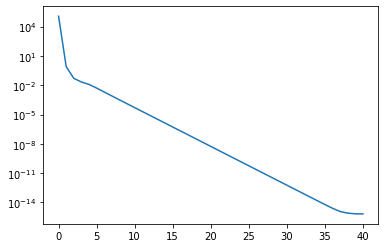

In [97]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_sm])

In [102]:
shift = 7
middle_eigv, conv_m = shift_inverse_iteration_fast(A, x0, num_iter, shift)
print(middle_eigv @ A @ middle_eigv)

6.992228493059952


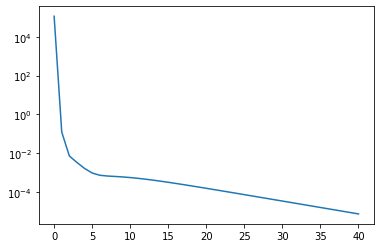

In [103]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_m])

In [104]:
shift = 7
large_eigv, conv_l = shift_inverse_iteration(A, x0, num_iter, shift)
print(large_eigv @ A @ large_eigv)

6.992228493059952


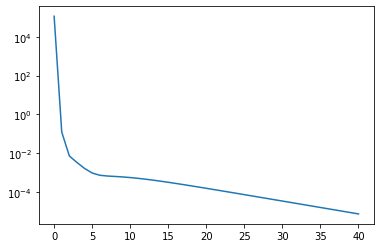

In [105]:
res = np.array([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_l])
plt.semilogy(res)

## Метод Релея

- Адаптивный сдвиг на каждой итерации

$$ \sigma_k = \frac{(Ax_k, x_k)}{(x_k, x_k)} $$

In [106]:
def rayleigh_quotient_iteration(A, x0, num_iter, shift):
    x = x0.copy()
    x = x / np.linalg.norm(x)
    conv = [x]
    n = A.shape[0]
    for i in range(1):
        x = np.linalg.solve(A - shift * np.eye(n), x)
        x = x / np.linalg.norm(x)
        conv.append(x)
        
    for i in range(num_iter):
        lam = x @ A @ x
        x = np.linalg.solve(A - lam * np.eye(n), x)
        x = x / np.linalg.norm(x)
        conv.append(x)
    return x, conv

In [110]:
eigv_rq, conv_rq = rayleigh_quotient_iteration(A, x0, num_iter, 7.)

In [111]:
print(eigv_rq @ A @ eigv_rq)
print(np.sort(np.linalg.eigvalsh(A)))
print(x0)

6.992228533552932
[0.01811231 0.04519876 0.04519876 ... 7.95480124 7.95480124 7.98188769]
[ 0.25665493 -1.23724391  1.60446583 ...  0.24743374 -0.29562927
  1.14999884]


[1.89789243e+00 1.21314070e-01 1.32531566e-04 8.11727899e-07
 3.23598523e-13 2.40727774e-15 2.27862475e-15 3.17035131e-15
 1.77829958e-15 2.01790993e-15 1.77494928e-15 1.56757314e-15
 1.60813439e-15 1.52801119e-15 1.61379221e-15 1.59361975e-15
 1.62471396e-15 1.70191047e-15 2.30138098e-15 1.50819493e-15
 1.52370035e-15 1.52846982e-15 1.81663206e-15 1.74373134e-15
 1.90911123e-15 1.57494886e-15 3.20245019e-15 1.53502909e-15
 1.87027368e-15 1.64262216e-15 1.86028201e-15 1.63206942e-15
 2.32600653e-15 3.18078087e-15 1.89426563e-15 1.78238821e-15
 1.67673786e-15 1.90365873e-15 1.54222803e-15 1.56701285e-15
 1.63213639e-15 1.55712700e-15]


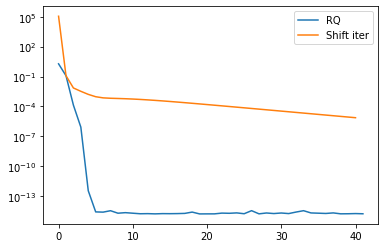

In [112]:
res = np.array([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_rq])
plt.semilogy(res, label="RQ")
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_l], label="Shift iter")
plt.legend()
print(res)

## Как найти другие собственные значения?



In [113]:
B = A - eigv_rq @ (A @ eigv_rq) * np.outer(eigv_rq, eigv_rq)
print(np.sort(np.linalg.eigvals(B)))

[0.         0.01811231 0.04519876 ... 7.95480124 7.95480124 7.98188769]


In [115]:
eigv_rq_B, conv_rq_B = rayleigh_quotient_iteration(B, x0, num_iter, 7.)
print(eigv_rq_B @ B @ eigv_rq_B)

6.992228533552932


In [116]:
C = B - eigv_rq_B @ (A @ eigv_rq_B) * np.outer(eigv_rq_B, eigv_rq_B)
print(np.sort(np.linalg.eigvals(C)))

[1.20120895e-14+0.j 1.24344979e-14+0.j 1.81123097e-02+0.j ...
 7.95480124e+00+0.j 7.95480124e+00+0.j 7.98188769e+00+0.j]


In [117]:
eigv_rq_C, conv_rq_C = rayleigh_quotient_iteration(C, x0, num_iter, 7.)
print(eigv_rq_C @ C @ eigv_rq_C)

6.9909438451461705


### И так далее для других собственных векторов....

- Какая правильная стратегия использования метода Релея?

## Матричные функции: введение


$$ B = f(A) = \sum_{k=0}^{\infty} c_k A^k$$

- Это не поэлементная функция
- Нужно уметь вычислять ряд
- Устойчивость

## Вычисление степени матрицы

- Дана матрица $A$
- Нужно вычислить $A^k$
- Это необходимо при вычисление матричных функций, которые представляются в виде матричного ряда

### Используем спектральное разложение

- $A = U\Lambda U^{-1}$
- Тогда $A^k = U \Lambda^k U^{-1}$

### Матричная экспонента: знакомство или напоминание

$$\exp(A) = \sum_{k=0}^{\infty} \frac{A^k}{k!} $$

- Про матричные функции будет отдельное занятие!
- Важно! Чаще нужно не само значение матричной экспоненты, а результат её умножения на некоторый вектор $v$: 

$$ \exp(A)v $$

- Это позволяет разработать быстрые методы для вычисления произведения, не считая саму матричную экспоненту!

In [60]:
import numpy as np
import scipy.linalg as splin
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
%matplotlib inline 

n = 50
A = np.random.randn(n, n)
A = A + A.T
print(np.linalg.norm(A))
expA = splin.expm(A)
# print(expA.round(4))

72.9093498873854


In [61]:
def qr_algorithm(A, num_iter, eps):
    T = A.copy()
    U = np.eye(A.shape[0])
    conv = [(T, U)]
    for i in range(num_iter):
        Q, R = np.linalg.qr(T)
        T = R @ Q
        U = U @ Q
        conv.append((T, U))
        if np.sum(np.abs(np.tril(T, k=-1))) < eps:
            break
    return T, U, conv[1:]

In [62]:
T, U, conv = qr_algorithm(A, 4000, 1e-6)
print(np.linalg.norm(A - U @ T @ U.T))

5.017469844366763e-12


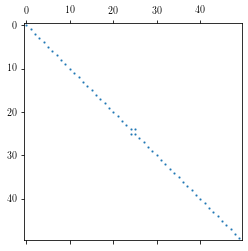

In [64]:
plt.spy(T, markersize=1, precision=1e-6)

In [66]:
cur_term = np.eye(n)
expA_approx = np.eye(n)
K = 200
denom = 1.
conv = [expA_approx]
for i in range(1, K):
    denom = denom * i
    cur_term = U @ T**i @ U.T / denom
    expA_approx = expA_approx + cur_term
    conv.append(expA_approx)
# print(expA_approx.round(4))
print(np.linalg.norm(expA_approx - expA) / np.linalg.norm(expA))

1.459217787080334e-11


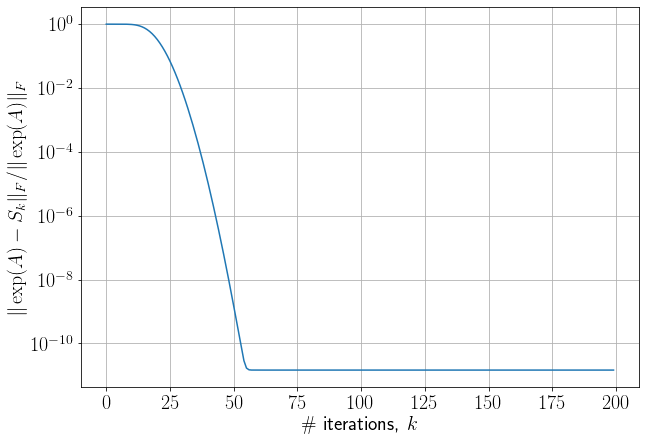

In [67]:
plt.figure(figsize=(10, 7))
plt.plot([np.linalg.norm(expA - approx, "fro") / np.linalg.norm(expA) for approx in conv])
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("\# iterations, $k$", fontsize=20)
plt.ylabel("$\|\exp(A) - S_k \|_F / \|\exp(A)\|_F$", fontsize=20)
plt.grid(True)

In [72]:
import scipy.special as spspec
expA_approx = np.zeros((n, n))
K = 200
denom = 1.
conv = [expA_approx]
for i in range(K - 1, 0, -1):
    cur_term = U @ T**i @ U.T / spspec.factorial(i)
    expA_approx = expA_approx + cur_term
    conv.append(expA_approx)
expA_approx = expA_approx + np.eye(n)
# print(expA_approx.round(4))
print(np.linalg.norm(expA_approx - expA) / np.linalg.norm(expA))

1.45921858916028e-11


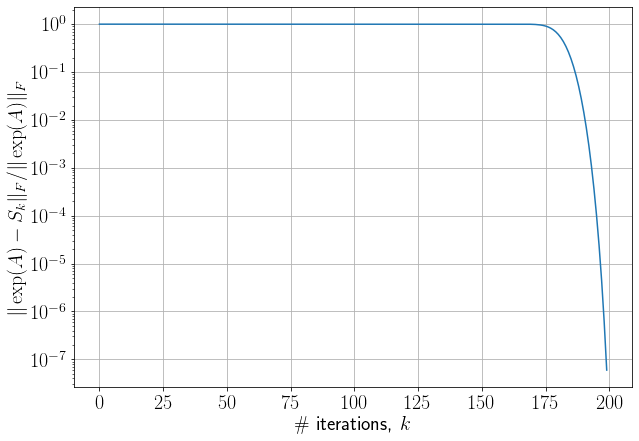

In [71]:
plt.figure(figsize=(10, 7))
plt.plot([np.linalg.norm(expA - approx, "fro") / np.linalg.norm(expA) for approx in conv])
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("\# iterations, $k$", fontsize=20)
plt.ylabel("$\|\exp(A) - S_k \|_F / \|\exp(A)\|_F$", fontsize=20)
plt.grid(True)

## Главное по семинару

- Сдвиги и ускорение методов поиска собственных значений
- Метод Релея
- Матричные функции для плотных матриц